# Імпорт необхідних бібліотек

In [2]:
import os, time, warnings
from pathlib import Path
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import re, string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

# Завантаження датасету

In [3]:
data_path = "Automobile.csv"
data = pd.read_csv(data_path)
df_original = data.copy()
missing_data = data.isnull().sum()

if missing_data.sum() > 0:
    print("\nПропущені значення виявлено. Видаляємо їх...")
    data = data.dropna()
def detect_outliers(df):
    outliers = pd.DataFrame()
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = ((df[col] < lower_bound) | (df[col] > upper_bound))
    
    return outliers

deleted_indices = df_original.index.difference(data.index)

df_deleted_rows = df_original.loc[deleted_indices]

print("\n--- Видалені рядки")
print(f"Загальна кількість видалених рядків: {len(df_deleted_rows)}")
print(df_deleted_rows)
print("\nПеревірка наявності викидів:")
outliers = detect_outliers(data)


Пропущені значення виявлено. Видаляємо їх...

--- Видалені рядки
Загальна кількість видалених рядків: 6
                     name   mpg  cylinders  displacement  horsepower  weight  \
32             ford pinto  25.0          4          98.0         NaN    2046   
126         ford maverick  21.0          6         200.0         NaN    2875   
330  renault lecar deluxe  40.9          4          85.0         NaN    1835   
336    ford mustang cobra  23.6          4         140.0         NaN    2905   
354           renault 18i  34.5          4         100.0         NaN    2320   
374        amc concord dl  23.0          4         151.0         NaN    3035   

     acceleration  model_year  origin  
32           19.0          71     usa  
126          17.0          74     usa  
330          17.3          80  europe  
336          14.3          80     usa  
354          15.8          81  europe  
374          20.5          82     usa  

Перевірка наявності викидів:


# Поділ на набори

In [4]:
data = data.drop(data.columns[[8, 0]], axis=1)
data = data[(data['cylinders'] != 3) & (data['cylinders'] != 5)]
label_encoder = LabelEncoder()
data['cylinders'] = label_encoder.fit_transform(data['cylinders'])
print(data['cylinders'].value_counts())
X = data.drop(columns=['cylinders'])
y = data['cylinders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Підготовка даних завершена. Розміри наборів:")
print(f"Тренувальні ознаки (X_train): {X_train.shape}")
print(f"Тестові ознаки (X_test): {X_test.shape}")

cylinders
0    199
2    103
1     83
Name: count, dtype: int64
Підготовка даних завершена. Розміри наборів:
Тренувальні ознаки (X_train): (269, 6)
Тестові ознаки (X_test): (116, 6)


# 1 завдання

In [5]:
knn = KNeighborsClassifier(n_neighbors=5)

start = time.time()
knn.fit(X_train, y_train)
train_time_orig = time.time() - start

y_pred = knn.predict(X_test)
acc_orig = accuracy_score(y_test, y_pred)

print(f"Точність на початкових даних: {acc_orig:.4f}, час навчання: {train_time_orig:.46}s")
print(classification_report(y_test, y_pred))

# ===== PCA =====
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
X_pca = pca.fit_transform(X)

print(f"Кількість компонент PCA, що залишилися: {X_pca.shape[1]}")

Xp_train, Xp_test, yp_train, yp_test = train_test_split(
    X_pca, y, test_size=0.25, random_state=42, stratify=y
)

knn2 = KNeighborsClassifier(n_neighbors=5)

start = time.time()
knn2.fit(Xp_train, yp_train)
train_time_pca = time.time() - start

yp_pred = knn2.predict(Xp_test)
acc_pca = accuracy_score(yp_test, yp_pred)

print(f"Точність після PCA: {acc_pca:.4f}, час навчання: {train_time_pca:.6f}s")
print(classification_report(yp_test, yp_pred))

Точність на початкових даних: 0.9483, час навчання: 0.0009973049163818359375s
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        60
           1       0.91      0.84      0.87        25
           2       1.00      0.94      0.97        31

    accuracy                           0.95       116
   macro avg       0.95      0.93      0.94       116
weighted avg       0.95      0.95      0.95       116

Кількість компонент PCA, що залишилися: 1
Точність після PCA: 0.8866, час навчання: 0.000000s
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        50
           1       0.87      0.62      0.72        21
           2       0.92      0.88      0.90        26

    accuracy                           0.89        97
   macro avg       0.89      0.83      0.85        97
weighted avg       0.89      0.89      0.88        97



# Візуалізація PCA vs t-SNE

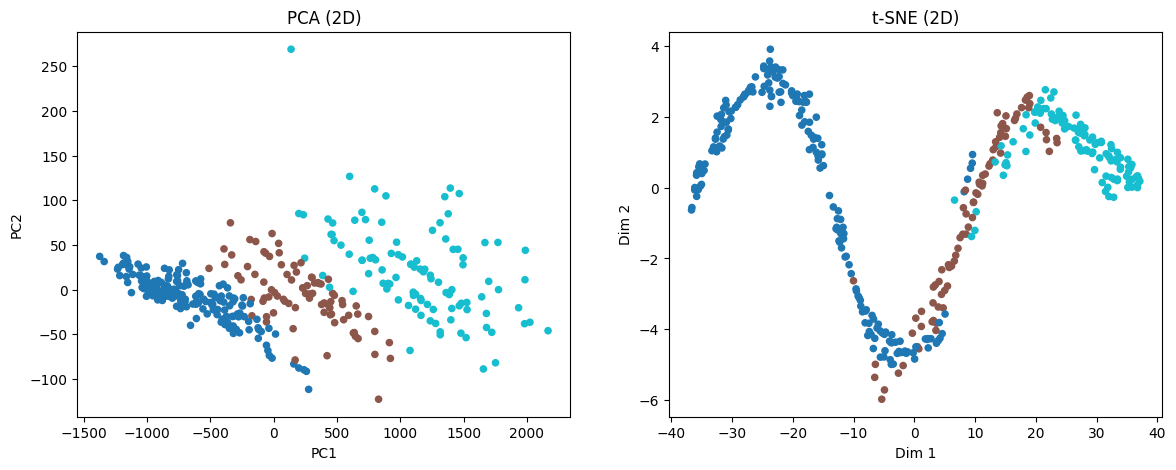

In [6]:
# PCA до 2-х компонент для графіка
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
X_tsne = tsne.fit_transform(X)

# Побудова графіків
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y, s=20, cmap='tab10')
plt.title("PCA (2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.subplot(1,2,2)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=20, cmap='tab10')
plt.title("t-SNE (2D)")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")

plt.show()

# 2. K-means квантування зображення

Оригінальне зображення:


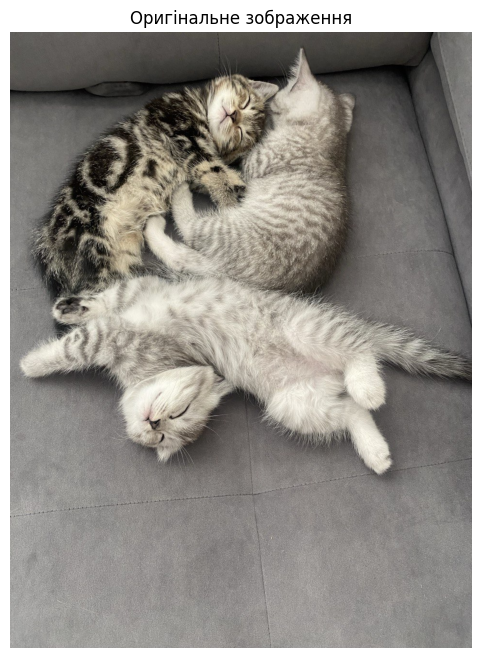


Квантовані зображення:
Обчислення для K=64...
Обчислення для K=32...
Обчислення для K=16...
Обчислення для K=8...


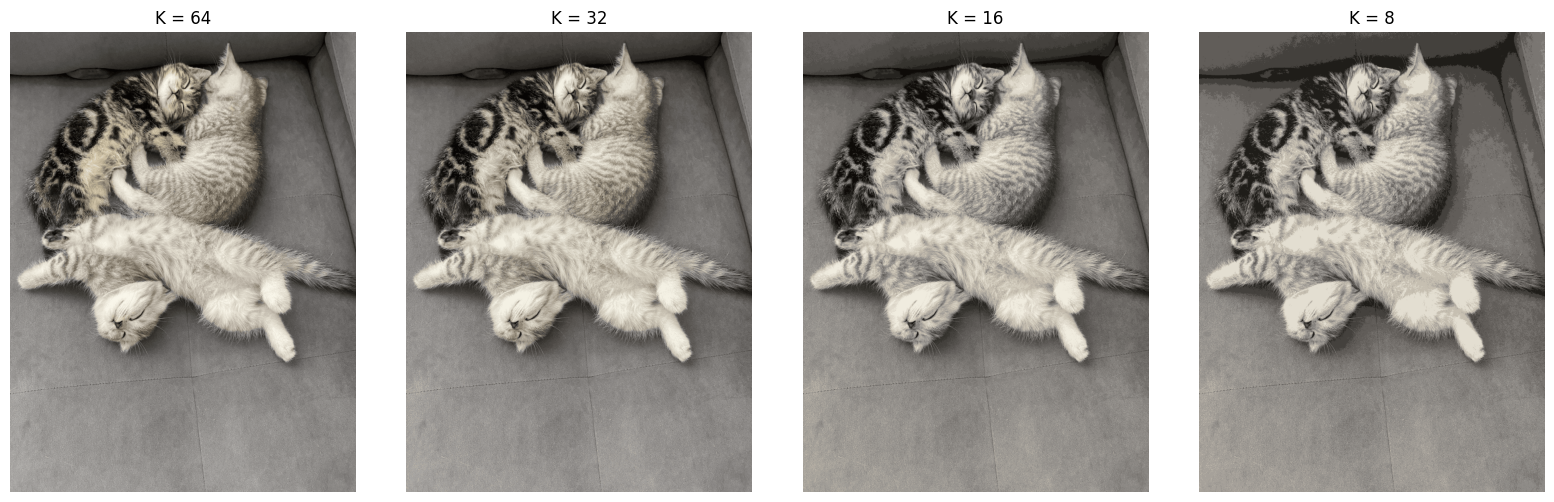

In [65]:
image_path = "image.jpg"
k_values = [64, 32, 16, 8]
img = Image.open(image_path)
img_np = np.array(img)

h, w, ch = img_np.shape
# Нормалізація пікселів (R, G, B) для KMeans
pixels = img_np.reshape(-1, 3) / 255.0

# --- Виведення Оригінального Зображення ---
print("Оригінальне зображення:")
plt.figure(figsize=(8, 8))
plt.imshow(img_np)
plt.title("Оригінальне зображення")
plt.axis('off')
plt.show()

# 2. Квантування та Відображення
print("\nКвантовані зображення:")
fig, axes = plt.subplots(1, len(k_values), figsize=(4 * len(k_values), 5))

for i, k in enumerate(k_values):
    print(f"Обчислення для K={k}...")

    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(pixels)
    centers = km.cluster_centers_

    # Створення нового зображення з центрами кластерів
    new_pixels = centers[labels].reshape(h, w, 3)
    qimg_np = (new_pixels * 255).astype(np.uint8)

    # Відображення
    ax = axes[i]
    ax.imshow(qimg_np)
    ax.set_title(f"K = {k}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# 3  Завдання Phishing_Email


Перші 5 рядків:
                                          Email Text      Email Type
0  re : 6 . 1100 , disc : uniformitarianism , re ...      Safe Email
1  the other side of * galicismos * * galicismo *...      Safe Email
2  re : equistar deal tickets are you still avail...      Safe Email
3  \nHello I am your hot lil horny toy.\n    I am...  Phishing Email
4  software at incredibly low prices ( 86 % lower...  Phishing Email

Перші 5 рядків очищенного:
<bound method NDFrame.head of                                               Email Text      Email Type
0      6 1100 disc uniformitarianism 1086 sex lang di...      Safe Email
1      side galicismos galicismo spanish term names i...      Safe Email
2      equistar deal tickets still available assist r...      Safe Email
3      hello hot lil horny toy one dream open minded ...  Phishing Email
4      software incredibly low prices 86 lower draper...  Phishing Email
...                                                  ...             ...


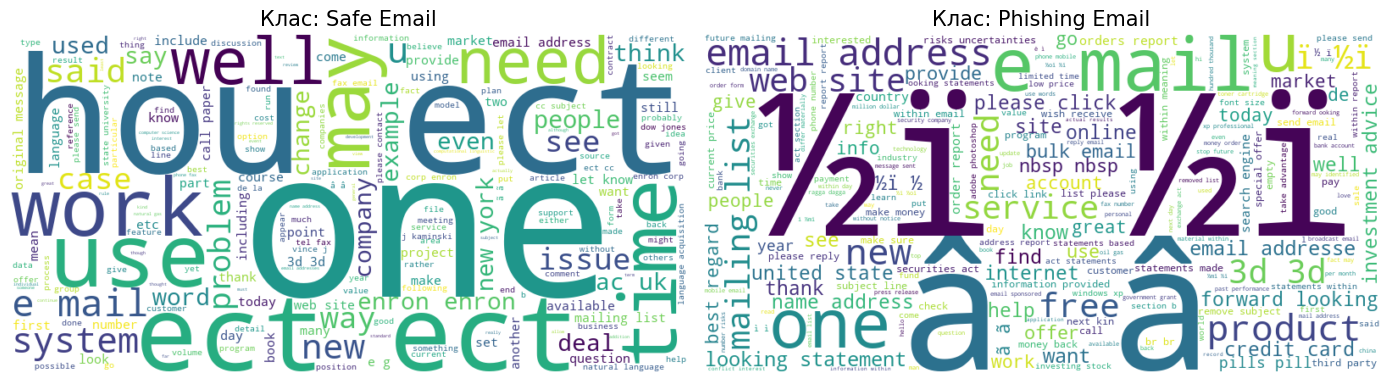

Точність класифікації: 0.9336767546683837
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1828
           1       0.92      0.98      0.95      2831

    accuracy                           0.93      4659
   macro avg       0.94      0.92      0.93      4659
weighted avg       0.94      0.93      0.93      4659



In [18]:
file_path = "Phishing_Email.csv"
df = pd.read_csv(file_path)
df = df.drop(df.columns[0], axis=1)
df.dropna(subset=['Email Text'], inplace=True)
print("\nПерші 5 рядків:")
print(df.head())

#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Функція передобробки тексту
def preprocess_text(t):
    t = t.lower()
    # Видалення URL
    t = re.sub(r"http\S+", "", t)
    # Видалення пунктуації
    t = t.translate(str.maketrans("", "", string.punctuation))
    # видалення стоп-слів
    tokens = [w for w in t.split() if w not in stop_words]
    return " ".join(tokens)

# Застосування передобробки 
df["Email Text"] = df["Email Text"].apply(preprocess_text)
print("\nПерші 5 рядків очищенного:")
print(df.head)


labels = df["Email Type"].unique()
fig, axes = plt.subplots(1, len(labels), figsize=(14, 7)) 

for i, label in enumerate(labels):
    text_join = " ".join(df[df["Email Type"] == label]["Email Text"])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text_join)
    # Виводимо зображення
    ax = axes[i]
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f"Клас: {label}", fontsize=15)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

# TF-IDF та Навчання Моделі 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder # для кодування міток

vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(df["Email Text"])
y_text = LabelEncoder().fit_transform(df["Email Type"])

Xtr, Xte, ytr, yte = train_test_split(X_text, y_text, test_size=0.25, random_state=42, stratify=y_text)

model = MultinomialNB()
model.fit(Xtr, ytr)
pred = model.predict(Xte)

print("Точність класифікації:", accuracy_score(yte, pred))
print(classification_report(yte, pred))
